In [1]:
from itertools import chain
from random import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from society.action import Action
from society.agent import Agent
from society.simulations.adaptive import AdaptiveSimulation
from society.agents.constant import AllC, AllD
from society.agents.qlearning import TabularQLearner
from society.agents.random import Random
from society.agents.tft import TitForTat
from society.visualisation.network import *

# plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
# def generate_population(communities, size):
#     population = communities * size

#     agents = [
#         TabularQLearner(lookback=1, epsilon=0.1, learning_rate=0.05)
#         for i in range(population)
#     ]

#     G = nx.connected_caveman_graph(communities, size)

#     weights_matrix = np.zeros((population, population))
#     for u, v, d in G.edges(data=True):
#         weights_matrix[u, v] = weights_matrix[v, u] = 1
#         try:
#             d["weight"] = weights_matrix[u, v]
#         except:
#             d["weight"] = 0

#     return agents, weights_matrix, G

In [3]:
def generate_population(communities, size):
    population = communities * size

    agents = [
        TabularQLearner(
            lookback=1, epsilon=0.1, learning_rate=0.5, discount_factor=0.98
        )
        for i in range(population)
    ]

    # agents[0] = TitForTat()
    # agents[16] = TitForTat()
    # agents[16] = TitForTat()
    # agents[31] = TitForTat()

    G = nx.connected_caveman_graph(communities, size)

    # G = nx.Graph()
    # G.add_weighted_edges_from([
    #     (0, i, 1) for i in range(1, population)
    # ])

    weights_matrix = np.zeros((population, population))
    for u, v, d in G.edges(data=True):
        weights_matrix[u, v] = weights_matrix[v, u] = 1
        try:
            d["weight"] = weights_matrix[u, v]
        except:
            d["weight"] = 0

    return agents, weights_matrix, G

In [4]:
# _, _, G = generate_population(2, 16)

# nx.draw(G, pos=nx.spring_layout(G), font_color="white", with_labels=True)

In [8]:
def compute_policies(agents):
    policies = [
        agent._q_table.argmax(axis=-1) if hasattr(agent, "_q_table") else None
        for agent in agents
    ]

    return [
        "".join(
            [
                ("C", "D")[policy[i]]
                for i in range(4)
                # for j in range(4)
                # for k in range(4)
            ]
        )
        if policy is not None
        else "OTHER"
        for policy in policies
    ]


def calculate_cooperativeness(history):
    count = history.count(Action.COOPERATE)

    return count / len(history)

In [6]:
PAYOFF_LABELS = ["(C, C)", "(C, D)", "(D, C)", "(D, D)"]
# PAYOFF_LABELS = ["R", "S", "T", "P"]

In [7]:
POPULATION = (16, 4)
ROUNDS = 50_000

run_rewards = []
run_cumulative_rewards = []
# run_action_histories = []
run_reward_histories = []
run_policies = []

for run in range(1):
    # Generate a new population
    agents, weights_matrix, G = generate_population(*POPULATION)

    # Run a number of rounds
    sim = AdaptiveSimulation(agents, weights_matrix)

    # Run the simulation
    sim.reset()
    for i in tqdm(range(ROUNDS), desc=f"Run {run + 1}"):
        sim.play_round(train=True)

    # Store results
    run_rewards.append(sim.rewards)
    # run_action_histories.append(sim.action_histories)
    run_reward_histories.append(sim.reward_histories)
    run_policies.append(compute_policies(agents))

    # Output statistics for the best and worst agents
    cumulative_rewards = [
        (i, sum(history)) for i, history in enumerate(sim.reward_histories)
    ]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    # TODO: maybe I should switch to mean rewards (?)
    # mean_rewards = [(i, np.mean(history)) for i, history in enumerate(sim.reward_histories)]
    # mean_rewards.sort(key=lambda x: x[1], reverse=True)

    tqdm.write(
        f"BEST AGENT: {cumulative_rewards[0][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[0][0]])))}, {run_policies[-1][cumulative_rewards[0][0]]})"
    )
    tqdm.write(
        f"WORST AGENT: {cumulative_rewards[-1][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[-1][0]])))}, {run_policies[-1][cumulative_rewards[-1][0]]})"
    )

    for rh in sim.reward_histories:
        plt.plot(np.cumsum(rh))

    plt.show()

Run 1:   0%|          | 0/50000 [00:00<?, ?it/s]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

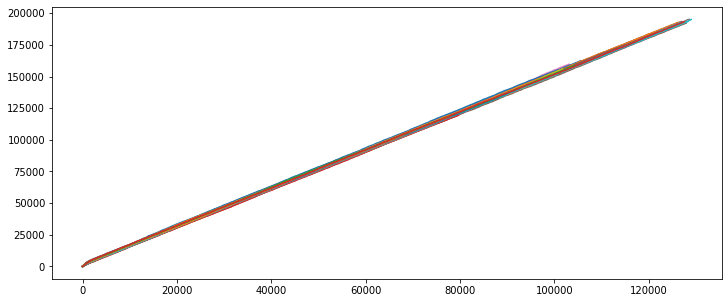

In [12]:
for rh in sim.reward_histories:
    plt.plot(np.cumsum(rh))

plt.show()

In [13]:
print(
    f"BEST AGENT: {cumulative_rewards[0][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[0][0]])))}, {run_policies[-1][cumulative_rewards[0][0]]})"
)
print(
    f"WORST AGENT: {cumulative_rewards[-1][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[-1][0]])))}, {run_policies[-1][cumulative_rewards[-1][0]]})"
)

BEST AGENT: 195178 (0.18917300483722957, DDDD)
WORST AGENT: 116989 (0.18069405664140406, DDDD)


In [ ]:
# plot_matrix(sim.frequencies, digits=0, figsize=(60, 36))

In [ ]:
sim.calculate_weights()

In [ ]:
sim.action_histories[0][2]

In [ ]:
cumulative_rewards[0][0]

In [ ]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

In [ ]:
agents[1]._q_table

In [ ]:
# from datetime import datetime
# import pickle

# with open(f"results - {datetime.isoformat(datetime.now()).replace(':', '-')}.pickle", "wb") as f:
#     pickle.dump({
#         "rewards": run_rewards,
#         "cumulative_rewards": run_cumulative_rewards,
#         # "action_histories": run_action_histories,
#         "reward_histories": run_reward_histories,
#         "policies": run_policies,
#     }, f)

In [ ]:
cumulative_reward_policy_ranks = {}
cumulative_reward_policies = {}

for policies, reward_histories in zip(run_policies, run_reward_histories):
    cumulative_rewards = [
        (i, sum(history)) for i, history in enumerate(reward_histories)
    ]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    for rank, (i, cumulative_reward) in enumerate(cumulative_rewards):
        policy = policies[i]

        if policy not in cumulative_reward_policy_ranks:
            cumulative_reward_policy_ranks[policy] = []
            cumulative_reward_policies[policy] = []

        cumulative_reward_policy_ranks[policy].append(rank + 1)
        cumulative_reward_policies[policy].append(cumulative_reward)

mean_cumulative_reward_policy_ranks = {
    policy: np.mean(ranks) for policy, ranks in cumulative_reward_policy_ranks.items()
}
mean_cumulative_reward_policies = {
    policy: np.mean(rewards) for policy, rewards in cumulative_reward_policies.items()
}

In [ ]:
for policy in sorted(
    mean_cumulative_reward_policy_ranks,
    key=lambda x: mean_cumulative_reward_policy_ranks[x],
):
    print(f"{mean_cumulative_reward_policy_ranks[policy]:<24} {policy}")

In [ ]:
for policy in sorted(
    mean_cumulative_reward_policies,
    key=lambda x: mean_cumulative_reward_policies[x],
    reverse=True,
):
    print(f"{mean_cumulative_reward_policies[policy]:<24} {policy}")

In [ ]:
compute_policies([agents[cumulative_rewards[0][0]]])[0]

In [ ]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    agents[cumulative_rewards[0][0]]._q_table

In [ ]:
from itertools import product

P = compute_policies([agents[cumulative_rewards[0][0]]])[0]

for m, p in zip(product(PAYOFF_LABELS, PAYOFF_LABELS), P):
    print(m, "=>", p)